# Task: Sobolev training of FFNNs
#### Using neural networks for reduced order modelling of the Euler-Bernoulli beam

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Content creators: Jasper O. Schommartz, Dominik K. Klein

Summer term 2024

---

#### In this notebook, you will...

* calibrate an FFNN to model the internal energy of a system.
* understand how the model can be built using Sobolev training.
* investigate the effect of including convexity conditions in the description of a potential

In [1]:
from os.path import join
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

K = tf.keras.backend
K.clear_session()

*Run the following two cells to clone the GitHub repository in your current Google Colab environment*

In [ ]:
!git clone https://github.com/CPShub/LecturePhysicsAwareML.git

In [ ]:
from LecturePhysicsAwareML.FFNN_ROM.src.data import read_data, static, dirac, step, sine, multisin
import LecturePhysicsAwareML.FFNN_ROM.src.plot as p
import LecturePhysicsAwareML.FFNN_ROM.src.evaluation as e

# Data path
path = join('LecturePhysicsAwareML', 'FFNN_ROM', 'data')

*Run the following cell to remove the clones repository.*

In [ ]:
%rm -rf LecturePhysicsAwareML

*Run the following cell if you are using Jupyter Notebook locally on your device.*

In [2]:
from src.data import read_data, static, dirac, step, sine, multisin
import src.plot as p
import src.evaluation as e

# Data path
path = 'data'

## 1. Recap of ROM with POD

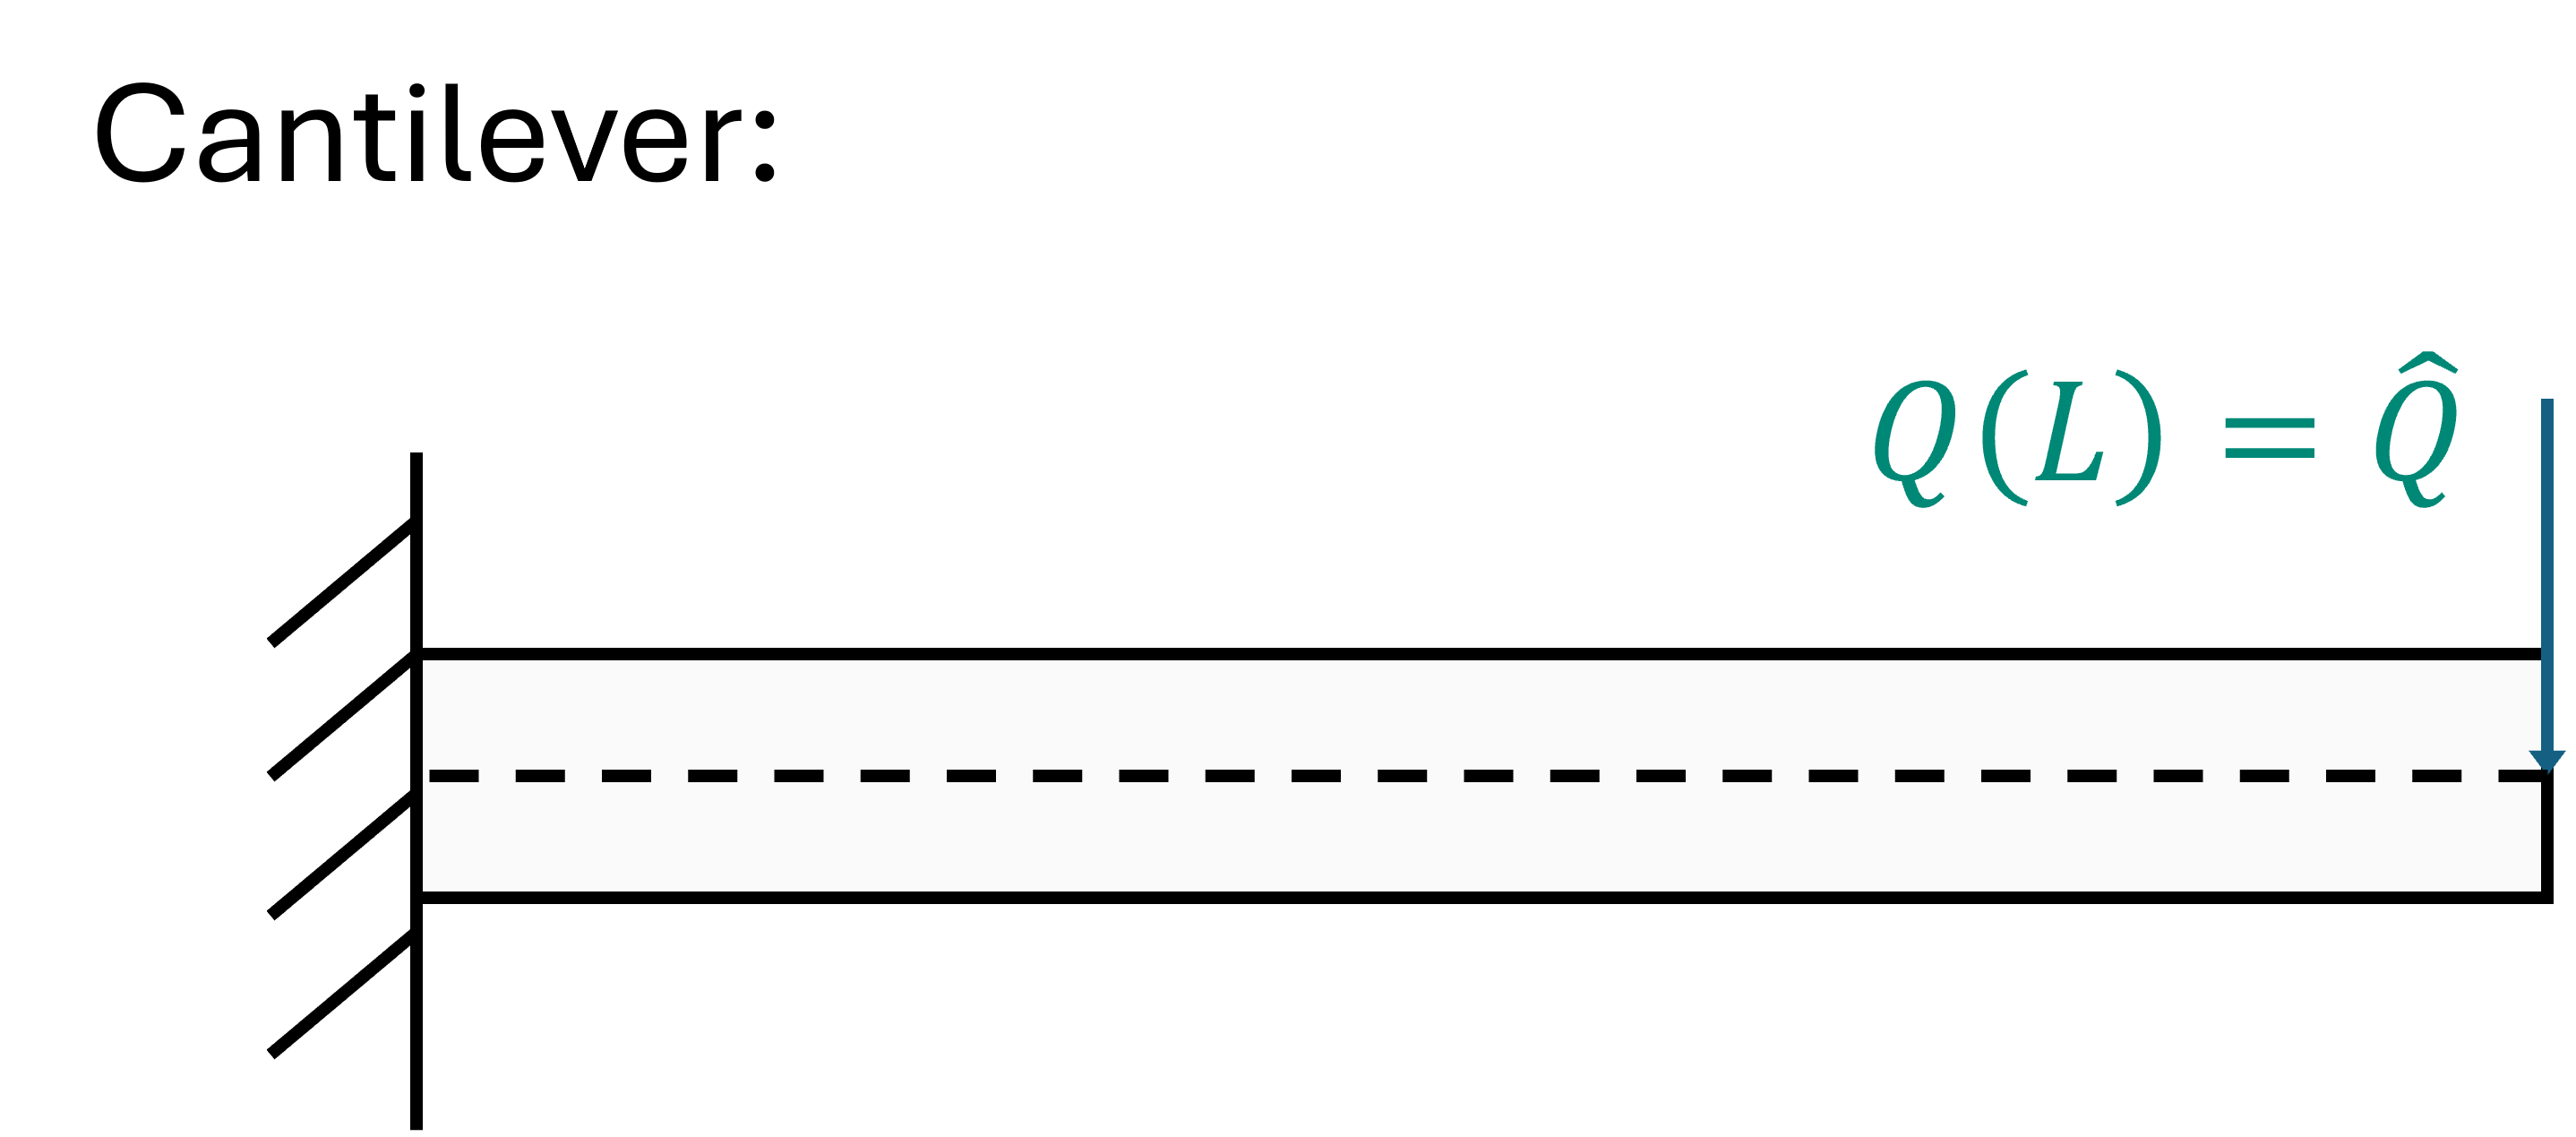

Proper orthogonal decomposition (POD) is a data-driven method for finding a reduced basis that approximates the behavior of a dynamical system. Based on the snapshot matrix $\mathbb{S} = (\boldsymbol{u}_1,\boldsymbol{u}_1, ...) \in \mathbb{R}^{N\times M}$, which contains time series data of the degrees of freedoms, e.g. displacements, the reduced basis $\boldsymbol{Q} = (\mathbb{u}_1, ..., \mathbb{u}_m) \in \mathbb{R}^{N \times m}$ is found using singular value decomposition (SVD).

After applying POD to the dynamics of the nonlinear Euler-Bernoulli beam, the behavior can be described by the following nonlinear differential equation

$$
\boldsymbol{Q}^T \boldsymbol{M} \boldsymbol{Q} \ddot{\boldsymbol{q}} + \tilde{\boldsymbol{f}}(\boldsymbol{q}) = \boldsymbol{Q}^T \boldsymbol{b}(t),
$$

where the nonlinear function $\tilde{\boldsymbol{f}}(\boldsymbol{q}) = \boldsymbol{Q}^T \boldsymbol{f}(\boldsymbol{Q}\boldsymbol{q})$ describes the internal forces in terms of the reduces degrees of freedom $\boldsymbol{q}$. The simulation of the equation above requires a time integration scheme. For this lecture the Newmark method was implemented in the `nlebb_dynamic_proj.m` MATLAB script. It makes use of the linearization of $\tilde{\boldsymbol{f}}(\boldsymbol{q})$, which is given in terms of the reduced stiffnes matrix $\tilde{\boldsymbol{K}} = \boldsymbol{Q}^T \boldsymbol{K} \boldsymbol{Q}$. $\tilde{\boldsymbol{K}}(\boldsymbol{q})$ is related to $\tilde{\boldsymbol{f}}(\boldsymbol{q})$ via the derivative as

$$
\tilde{\boldsymbol{K}(\boldsymbol{q})} = \frac{\partial \tilde{\boldsymbol{f}}(\boldsymbol{q})}{\partial \boldsymbol{q}}
$$

**Modelling the internal energy:**

We know that the linear Elastic beam is a conservative system, i.e, there is no damping and energy is preserved. Therefore, the existence of an internal energy $\psi(\boldsymbol{q})$ can be assumed, where the internal forces forces follow from the derivative with respect to the reduced DOFs $\boldsymbol{q}$ as

$$
\tilde{\boldsymbol{f}}(\boldsymbol{q}) = \frac{\partial \psi(\boldsymbol{q})}{\partial \boldsymbol{q}}.
$$

This relation can be implemented into the architecture of our FFNN based model to fulfill energy conservation by construction.

## 2. Task summary

In this task we aim to train a FFNN-based model that approximates the internal energy $\psi(\boldsymbol{q})$ of the nonlinear Euler-Bernoulli beam. It will be calibrated using Sobolev trainig with its first and second derivatives $\tilde{\boldsymbol{f}}(\boldsymbol{q})$ and $\tilde{\boldsymbol{K}(\boldsymbol{q})}$, respectively.

The task involves four step, where one is covered by this notebook:

1. Determination of the reduced basis using POD and SVD (`nlebb_dynamic_svd.m`)
2. Generation of training and test data sets for $\boldsymbol{q}$, $\tilde{\boldsymbol{f}}$, and $\tilde{\boldsymbol{K}}$ using the reduced basis (`nlebb_dynamic_proj.m`)
3. Training and evaluation of a FFNN-based surrogate model (this Jupyter Notebook)
4. Application of the FFNN in the beam simulation (`nlebb_dynamic_proj.m`)

## 3. FFNN-based model

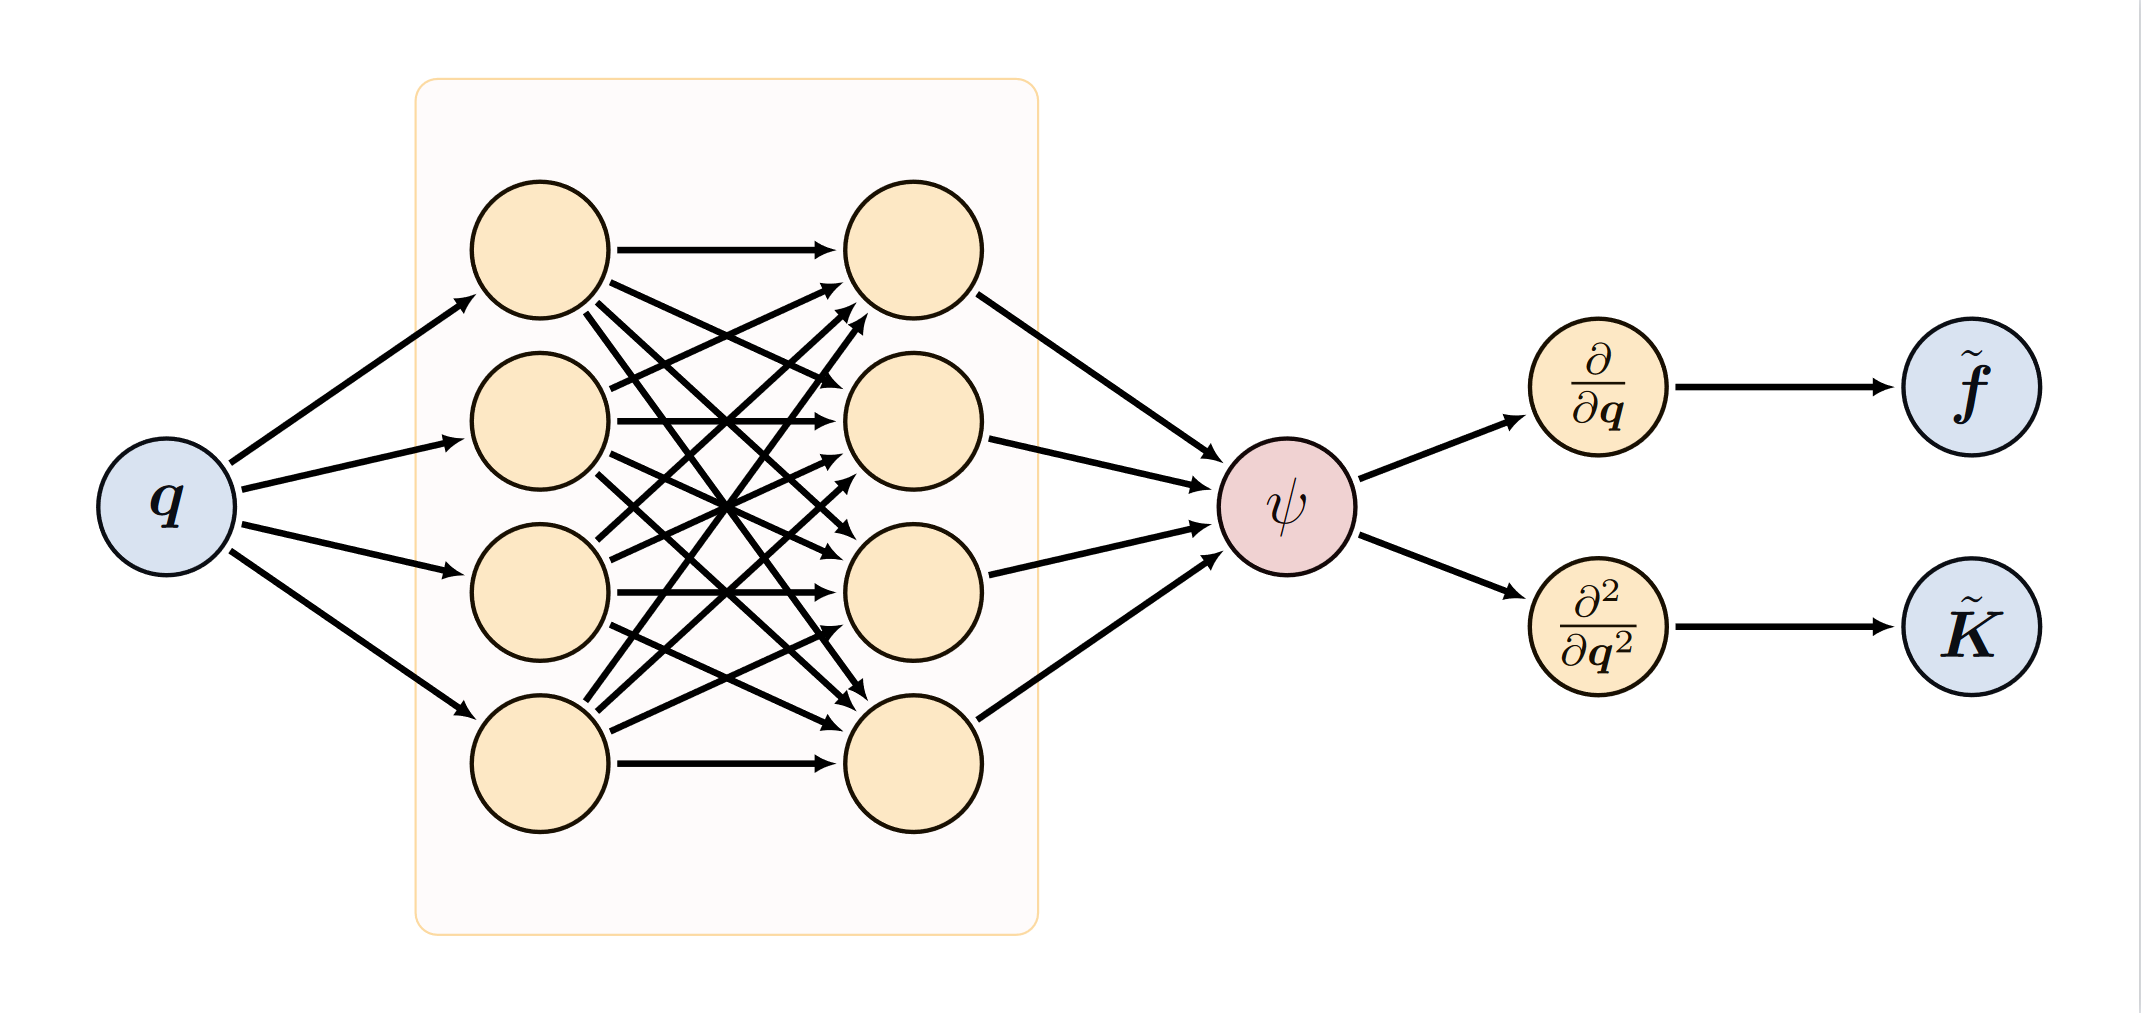

The model consists of of three custom layers. `MLP` represents the FFNN, which has a scalar output and returns the internal energy $\psi(\boldsymbol{q})$. `Hessian` computes the gradients of the FFNN with respect to its inputs, which corresponds to the internal force vector $\tilde{\boldsymbol{f}}(\boldsymbol{q})$, and the hessian matrix, which corresponds to the internal stiffness matrix $\tilde{\boldsymbol{K}(\boldsymbol{q})}$. The gradients are computed using automatic differentiation with the `tf.GradientTape()` module provided by Tensorflow.

In [3]:
class MLP(layers.Layer):
    ''' A feed-forward neural network '''
    def __init__(self, units, activation, non_neg):
        super().__init__()
        self.ls = []
        for (u, a, n) in zip(units, activation, non_neg):
            if n:
                kernel_constraint = tf.keras.constraints.non_neg()
            else:
                kernel_constraint = None
            self.ls += [layers.Dense(u, a, kernel_constraint=kernel_constraint)]  

    def call(self, x):    
        for l in self.ls:
            x = l(x)
        return x
    
class Hessian(layers.Layer):
    ''' Computes the gradient and hesian of another layer and returns
    it together with the function value '''
    def __init__(self, l):
        super().__init__()
        self.l = l # layer of which the gradient shall be computed
        self.flatten = layers.Flatten()

    def call(self, x):
        with tf.GradientTape() as g0:
            g0.watch(x)
            with tf.GradientTape() as g1:
                g1.watch(x)
                y = self.l(x)
            dy = g1.gradient(y, x)
        ddy = g0.batch_jacobian(dy, x)
        return y, dy, self.flatten(ddy)

To create the model, the `build()` function is called. It connects the input values to the output values and compiles the model with the desired optimizer and loss function. By setting the `loss_weights` property, the importance of every output can be adjusted for better training.

In this case the first component of `loss_weights` has to be zero, as we do not have data for the internal energy $\psi(\boldsymbol{q})$. The second component of `loss_weights` represents the weight of the error on $\tilde{\boldsymbol{f}}(\boldsymbol{q})$, while the third component represents the weight of the error on $\tilde{\boldsymbol{K}(\boldsymbol{q})}$. Here, the error is defined as the *mean squared error*, which is a typical choice in scientific machine learning.

In [4]:
def build(qm, loss_weights=[0, 1, 1], *args, **kwargs):
    ''' Builds an evaluation model that returns the nodal displacements '''
    # define input shape
    x = tf.keras.Input(shape=(qm,))
    # define which (custom) layers the model uses
    mlp = MLP(*args, **kwargs)
    hess = Hessian(mlp)
    y, dy, ddy = hess(x)
    # connect input and output
    model = tf.keras.Model(inputs = [x], outputs = [y, dy, ddy])
    # define optimizer
    model.compile('adam', 'mse', loss_weights=loss_weights)
    return model

## 4. Data generation and Preprocessing

Data generation is contucted a-priori via execution of the `nlebb_dynamic_svd.m`and `nlebb_dynamic_proj.m` scripts. The following types of excitations of the cantilever beam were used for data generation:

* Quasi-static: $Q(t) = A/5 \cdot t$
* Dirac: $Q(t) = A\ \text{if}\ 2.5 < t < 2.51$
* Step: $Q(t) = A\ \text{if}\ t > 2.5$
* Sine: $Q(t) = A \sin(2 \pi f t)$
* Multisine with phase shift: $Q_i(t) = \sum_{k=1}^{n} y_{i, k}(t)\quad$ with $\quad y_{i, k}(t) = A_k \sin(2 \pi f_k t + \varphi_k + \phi_i)\quad$ and $\quad \varphi_k = \frac{-k(k-1)}{n}\pi\quad$ and $\quad \phi_i = \frac{2 \pi (i -1)}{n_{ph}}$

**Training cases**:

* Multisine with $A = 2 N$, $n = 100$, $f_0 = 0.085 Hz$, $n_{ph} = 3$, $i = 1, ..., 3$ and a total simulation time of $t_{max} = 5s$

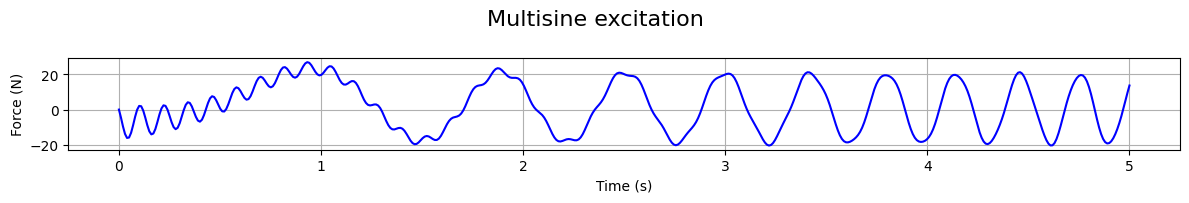

In [5]:
t = np.linspace(0, 5, 500)
multisin(2, 0.085, 100, 0, 3, t)

**Test cases**:

* Quasi-static with $A = -10$
* Dirac with $A = -10$
* Step with $A = -10$
* Sine with $A = 1.5 N$ and $f = 6 Hz$
* Multisine with $A = 1 N$, $n = 78$, $f_0 = 0.103 Hz$, $n_{ph} = 1$, $i = 1$

All training and test cases were simulated for a total time of $t_{max} = 5s$.

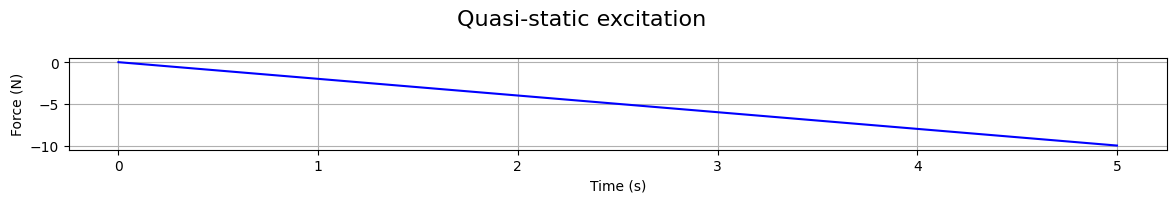

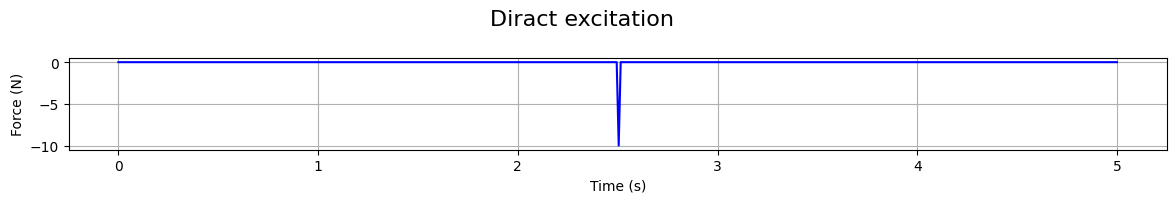

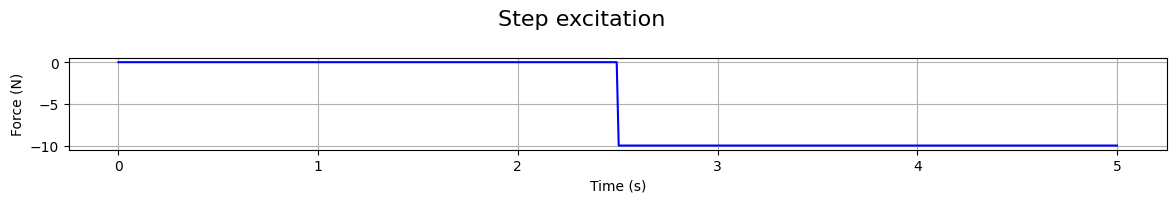

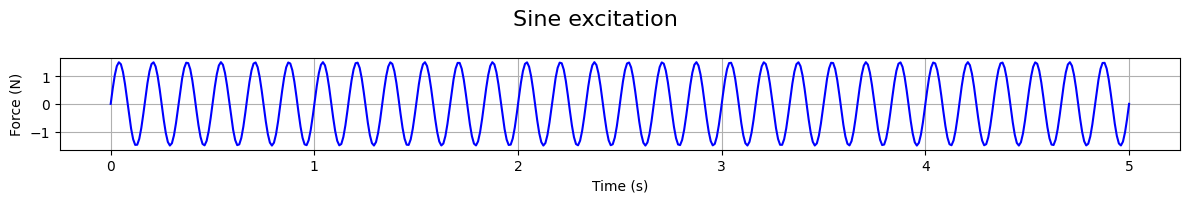

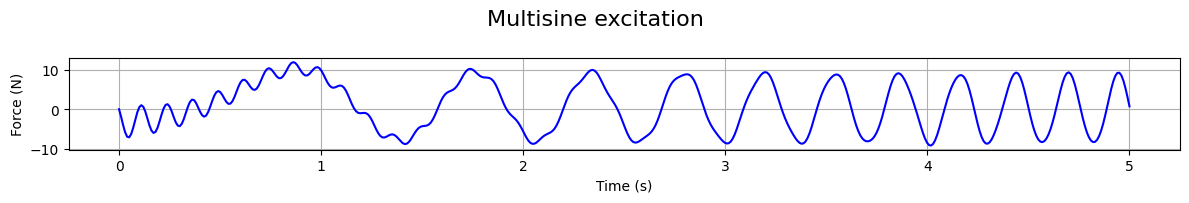

In [6]:
static(-10, t)
dirac(-10, 2.5, t)
step(-10, 2.5, t)
sine(1.5, 6, t)
multisin(1, 0.103, 78, 0, 1, t)

At first, the training data is loaded from the `Tasks/FFNN/data/` directory.

In [8]:
# Select training directory and files
dir_name = 'multisin_train'

fnames_q = ['q0all_1.txt', 'q0all_2.txt', 'q0all_3.txt']
fnames_Qf = ['Qfall_1.txt', 'Qfall_2.txt', 'Qfall_3.txt']
fnames_QKQ = ['QKQall_1.txt', 'QKQall_2.txt', 'QKQall_3.txt']

# Read data from txt files
q, Qf, QKQ = read_data(dir_name, fnames_q, fnames_Qf, fnames_QKQ)
m = q.shape[0]
n = q.shape[1]

The data is visualized to obtain an understanding of the data and indentify characteristics that could impact training. Important factors are, e.g.,

* the magnitude of values in the data set,
* the variety of the points in the data set.

**Task**: Take a look at the plotted data and try to answer the following questions:

* Why don't we normalize the data despite the discrepancy in the orders of magnitude?
* What other solutions are there for fitting data with different magnitudes?

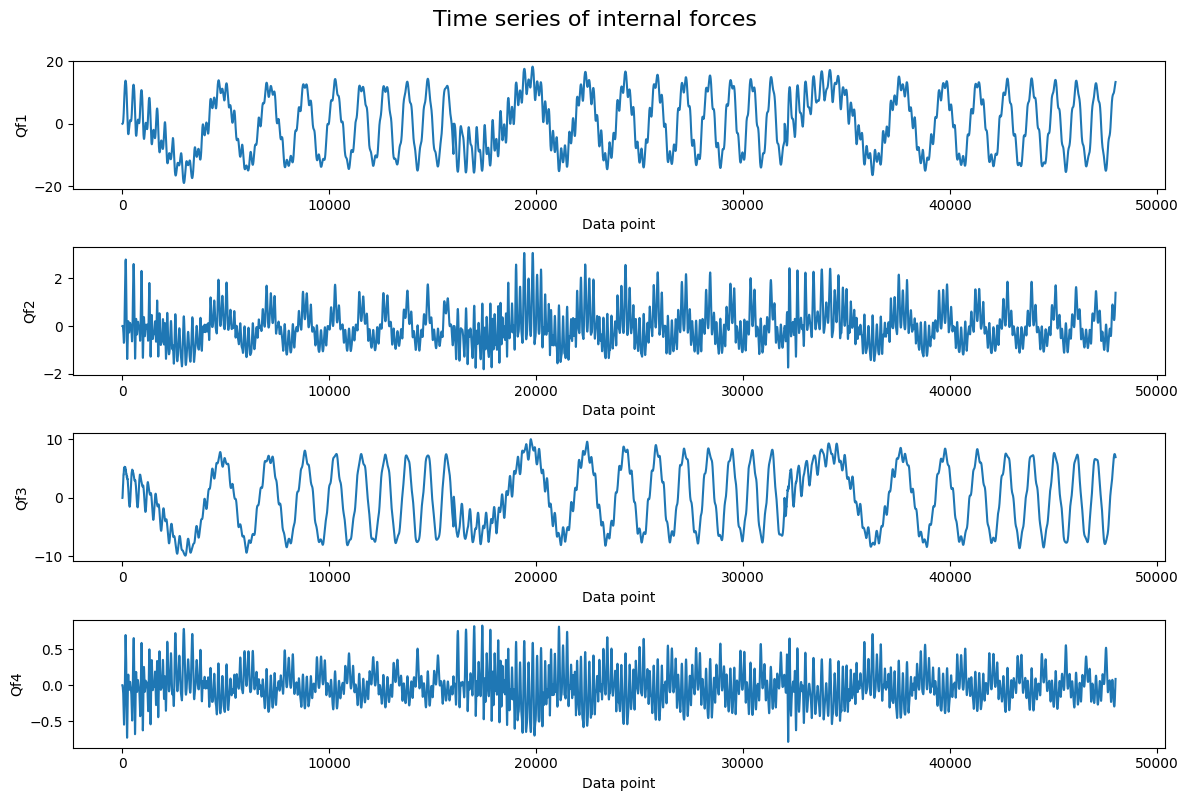

In [7]:
p.plot_forces(Qf)

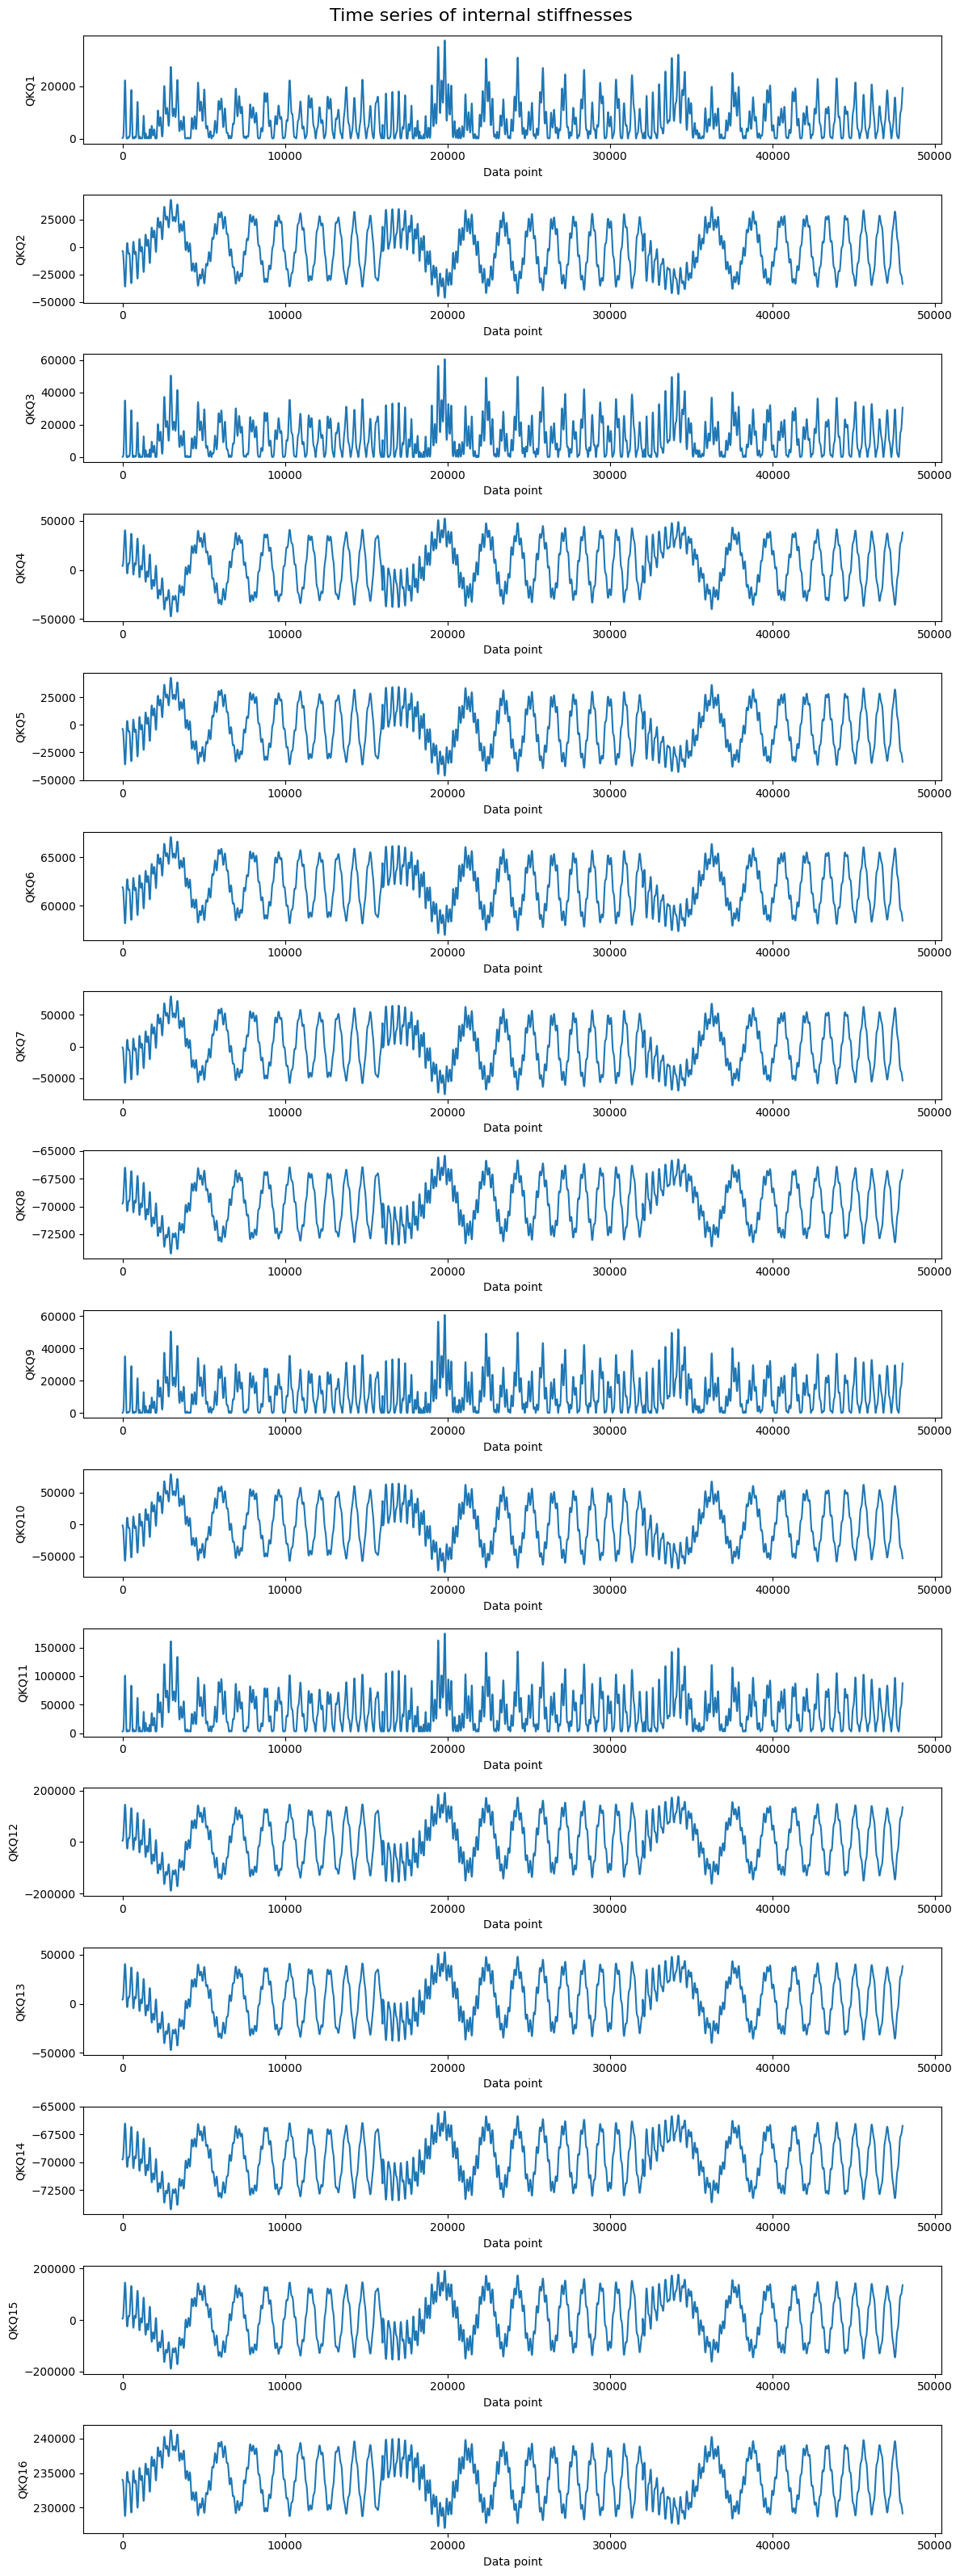

In [8]:
p.plot_stiffnesses(QKQ)

## 5. Buliding and calibrating the model

The `build()` function is called with the desired `loss_weights`, `units`, i.e., node number, `activation` and `non_neg` constraints.

**Task**: Make changes to the number of nodes as well as the loss weights and investigate the impact on model performance. Keep in mind that the first value of `loss_weights` must remain zero.

In [9]:
model = build(
    qm = n,
    loss_weights=[0, 1, 5e-7], # [0, 1, 5e-7],
    units=[16, 16, 1],
    activation=['softplus', 'softplus', 'linear'],
    non_neg=[False, False, False]
)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 hessian (Hessian)           ((None, 1),               369       
                              (None, 4),                         
                              (None, 16))                        
                                                                 
Total params: 369 (1.44 KB)
Trainable params: 369 (1.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Next, the model is fitted to the training data after defining the number of training epochs, i.e, `NEPOCHS`, and the learning rate for the ADAM optimizer.

**Tasks:**

* Make changes to the numper of epochs as well as the learning rate and investigate the impact on model performance.
* Why are we passing $q$ as output in the `model.fit()` function. Does is have an effect on the training? Explain your answer.

Epoch 1/10000
1501/1501 - 1s - loss: 2.3152 - hessian_loss: 1.4110 - hessian_1_loss: 2.0937 - hessian_2_loss: 443024.8125 - 999ms/epoch - 665us/step
Epoch 2/10000
1501/1501 - 1s - loss: 0.3325 - hessian_loss: 1.8695 - hessian_1_loss: 0.2890 - hessian_2_loss: 87026.6250 - 1s/epoch - 670us/step
Epoch 3/10000
1501/1501 - 1s - loss: 0.6520 - hessian_loss: 2.7990 - hessian_1_loss: 0.6000 - hessian_2_loss: 103945.2188 - 973ms/epoch - 648us/step
Epoch 4/10000
1501/1501 - 1s - loss: 0.8682 - hessian_loss: 2.8414 - hessian_1_loss: 0.8043 - hessian_2_loss: 127751.0234 - 973ms/epoch - 648us/step
Epoch 5/10000
1501/1501 - 1s - loss: 0.2507 - hessian_loss: 2.8774 - hessian_1_loss: 0.2073 - hessian_2_loss: 86726.6562 - 970ms/epoch - 646us/step
Epoch 6/10000
1501/1501 - 1s - loss: 0.3776 - hessian_loss: 2.8162 - hessian_1_loss: 0.3330 - hessian_2_loss: 89183.3359 - 965ms/epoch - 643us/step
Epoch 7/10000
1501/1501 - 1s - loss: 0.4855 - hessian_loss: 2.7914 - hessian_1_loss: 0.4372 - hessian_2_loss: 96

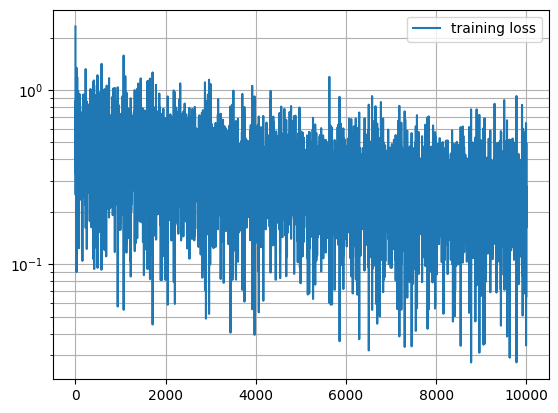

In [21]:
NEPOCHS = 10000
model.optimizer.learning_rate.assign(0.005)
h = model.fit([q], [q, Qf, QKQ],
              epochs=NEPOCHS,
              verbose=2,
              batch_size=32)

plt.semilogy(np.linspace(1, NEPOCHS, NEPOCHS), h.history['loss'], label='training loss')
plt.grid(which='both')
plt.legend()
plt.show()

The model is saved for later use and the weights are saved in a txt file for use in the beam simulation.

In [22]:
# Save model
model.save_weights('weights_02.h5')

# Save weights to list and txt-file
with open('weights_02.txt', 'w') as f:
    for weights in model.get_weights():
        weights = weights.reshape(-1)
        f.write(' '.join(str(val) for val in weights) + '\n')

*Run this cell if you want to load a pre-trained model*

In [10]:
# Weights file name
fname = 'weights_02_1_0.h5'

# Load weights to skip the training
model.load_weights(join(path, fname))

## 6. Evaluation

To evaluate the performance of the trained model, it must be tested on unseen data.

### 6.1 Evaluation on training data

However, in the first step we reevaluate the model on the training data to check that no underfitting has occured.

In [11]:
# Get model predictions
E_pred, Qf_pred, QKQ_pred = model(q)

# Evaluate
df_Qf_pred, df_QKQ_pred = e.evaluate(Qf, Qf_pred, QKQ, QKQ_pred)
df_Qf_pred

Qf1       Qf2       Qf3       Qf4
MSE  0.003709  0.041612  0.004175  0.006990
R2   0.999956  0.929351  0.999853  0.881377

In [12]:
df_QKQ_pred

QKQ1          QKQ2          QKQ3          QKQ4          QKQ5  \
MSE  9.172602e+07  4.300511e+08  2.494882e+08  5.693058e+08  4.300511e+08   
R2  -1.179529e+00 -7.217082e-03 -1.192884e+00 -4.626988e-02 -7.217082e-03   

             QKQ6          QKQ7          QKQ8          QKQ9         QKQ10  \
MSE  3.773763e+09  1.233084e+09  4.940890e+09  2.494882e+08  1.233084e+09   
R2  -6.834086e+02  4.291008e-02 -1.170939e+03 -1.192884e+00  4.291008e-02   

            QKQ11         QKQ12         QKQ13         QKQ14         QKQ15  \
MSE  2.220346e+09  7.917616e+09  5.693058e+08  4.940890e+09  7.917616e+09   
R2  -1.328313e+00 -1.228050e-02 -4.626988e-02 -1.170939e+03 -1.228050e-02   

            QKQ16  
MSE  5.468558e+10  
R2  -5.024383e+03

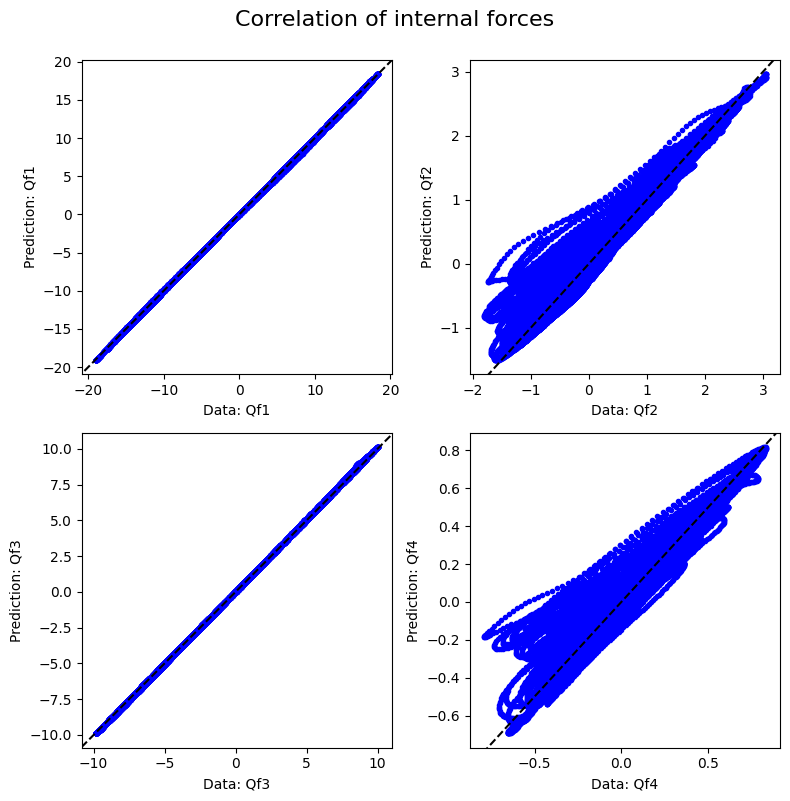

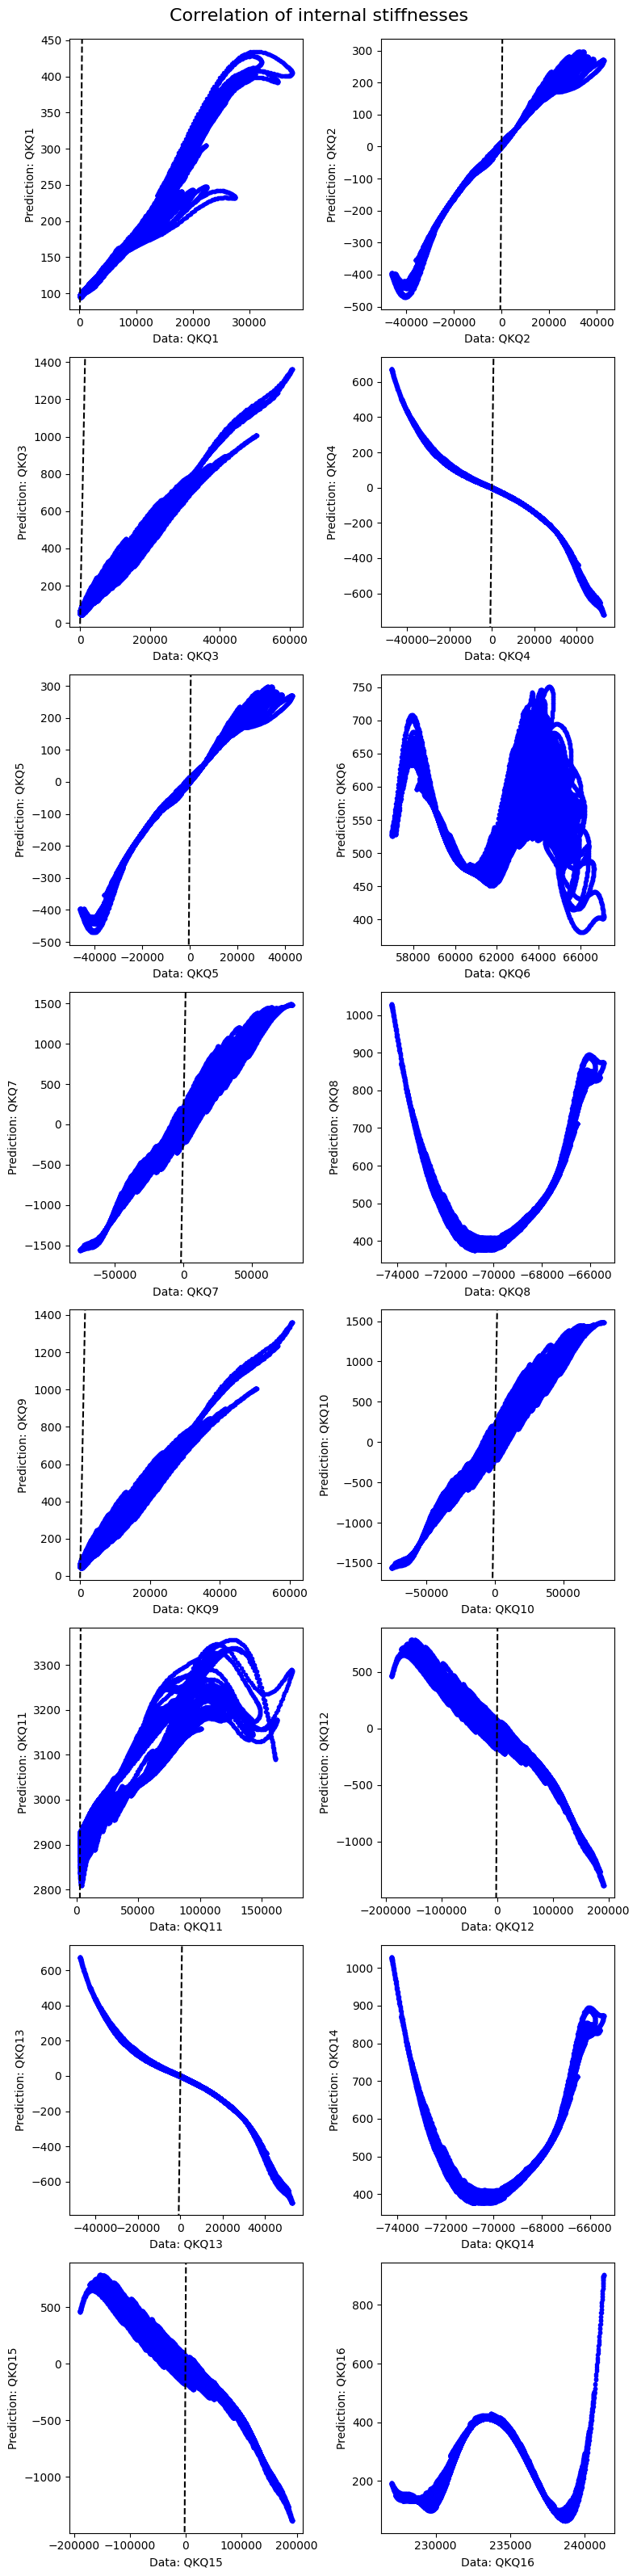

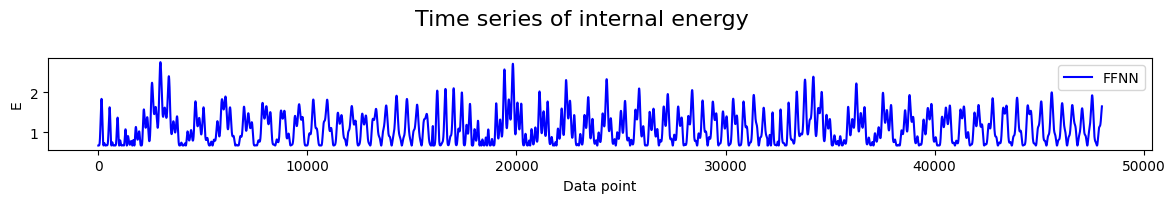

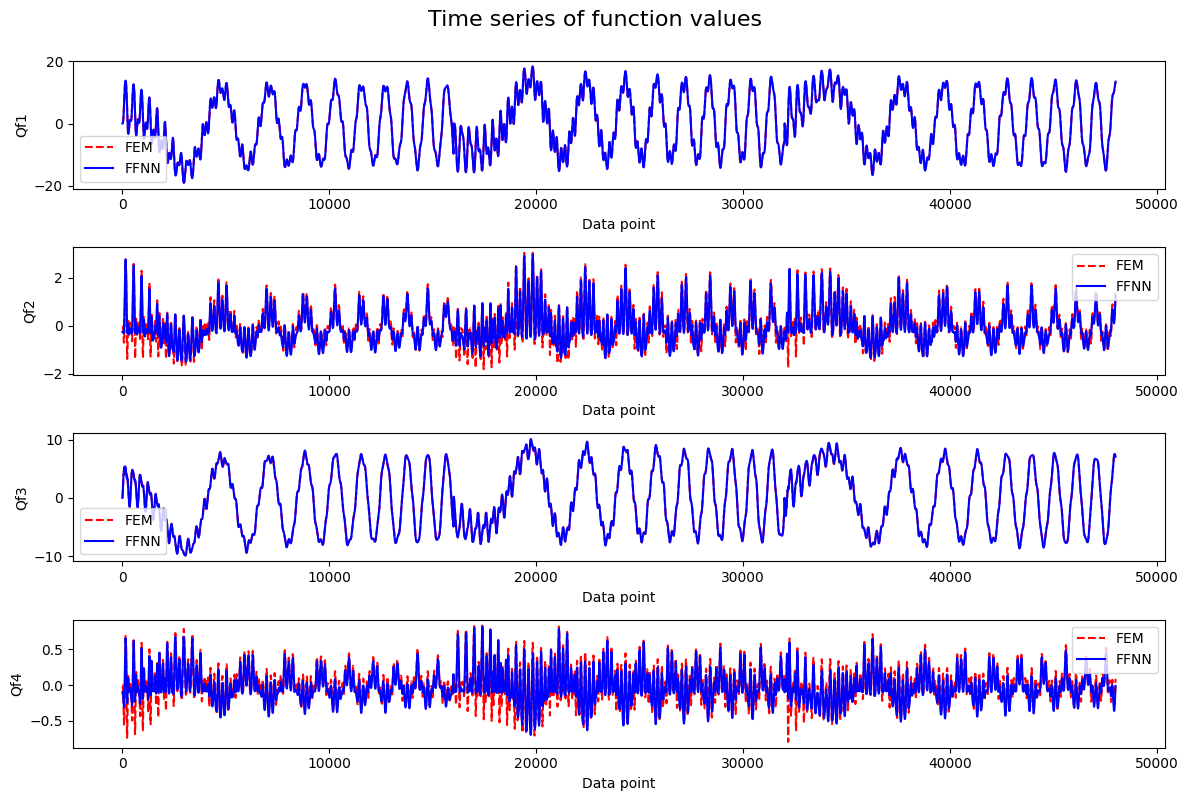

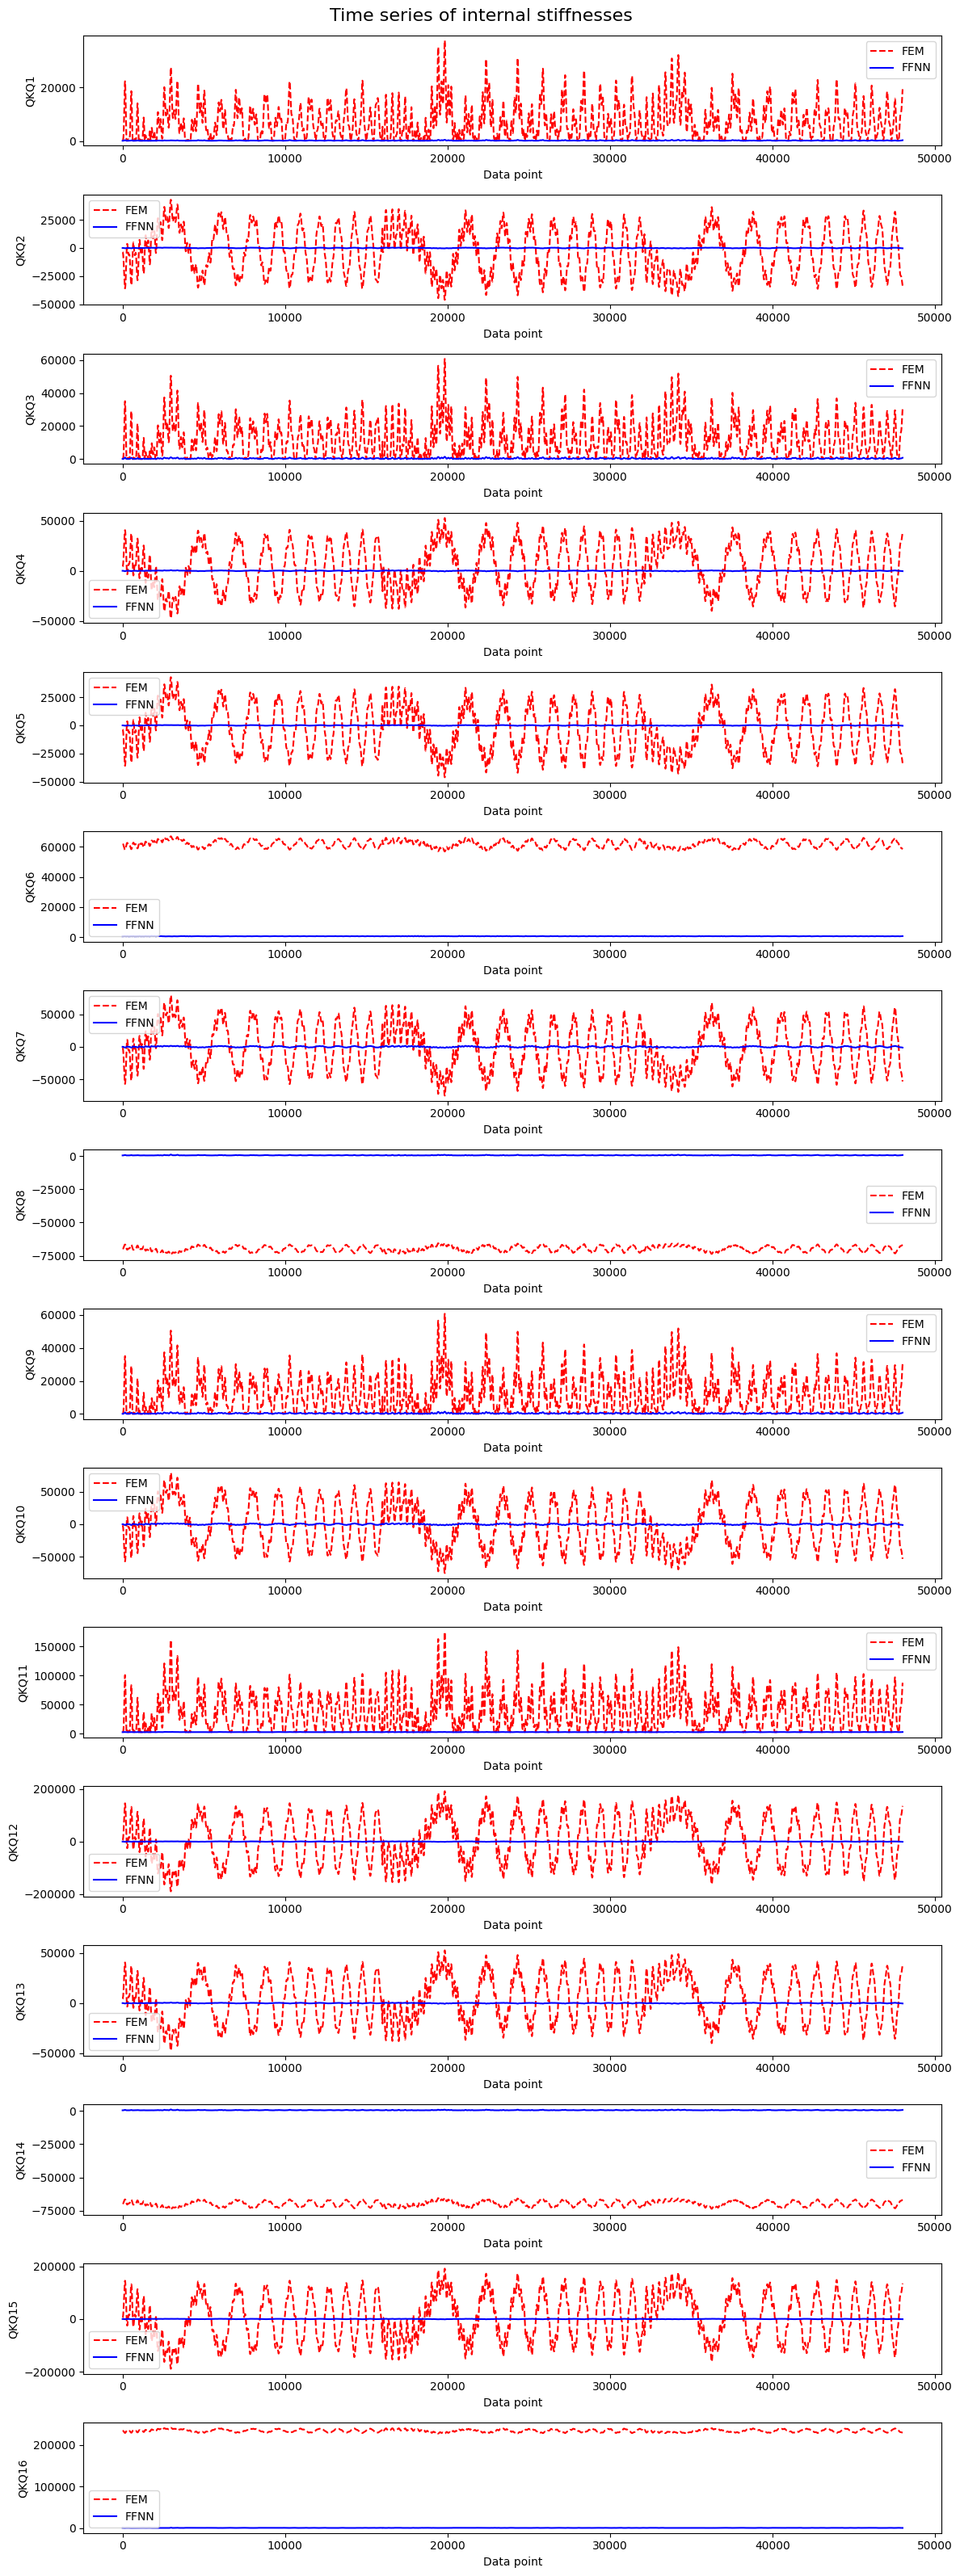

In [13]:
p.plot_predictions(q, Qf, Qf_pred, QKQ, QKQ_pred, E_pred)

### 6.2 Evaluation on testing data

Finally, the model is evaluated on the testing data.

In [14]:
# Select testing directory and files
dir_name = 'step_test' # Options: 'static_test', 'dirac_test', 'step_test', 'sin_test', 'multisin_test' 
fnames_q = ['q0all.txt']
fnames_Qf = ['Qfall.txt']
fnames_QKQ = ['QKQall.txt']

# Read files
q_test, Qf_test, QKQ_test = read_data(dir_name, fnames_q, fnames_Qf, fnames_QKQ)

# Get model predictions
E_pred_test, Qf_pred_test, QKQ_pred_test = model(q_test)

# Evaluate
df_Qf_test, df_QKQ_test = e.evaluate(Qf_test, Qf_pred_test, QKQ_test, QKQ_pred_test)

The mean squares errors and autocorrelations between the predicted and actual function values are

In [15]:
df_Qf_test

Qf1       Qf2       Qf3       Qf4
MSE  0.011719  0.125156  0.005167  0.014803
R2   0.999217  0.772966  0.998821  0.786858

The mean squares errors and autocorrelations between the predicted and actual derivatives are 

In [16]:
df_QKQ_test

QKQ1          QKQ2          QKQ3          QKQ4          QKQ5  \
MSE  2.789397e+07  1.857927e+08  6.136540e+07  2.448017e+08  1.857927e+08   
R2  -5.202188e-01 -1.461652e+00 -4.176984e-01 -1.603334e+00 -1.461652e+00   

             QKQ6          QKQ7          QKQ8          QKQ9         QKQ10  \
MSE  3.675260e+09  3.909463e+08  4.828823e+09  6.136540e+07  3.909463e+08   
R2  -3.689249e+03 -7.531763e-01 -6.519845e+03 -4.176984e-01 -7.531763e-01   

            QKQ11         QKQ12         QKQ13         QKQ14         QKQ15  \
MSE  4.699001e+08  2.671887e+09  2.448017e+08  4.828823e+09  2.671887e+09   
R2  -4.426021e-01 -9.111847e-01 -1.603334e+00 -6.519845e+03 -9.111847e-01   

            QKQ16  
MSE  5.408487e+10  
R2  -2.756378e+04

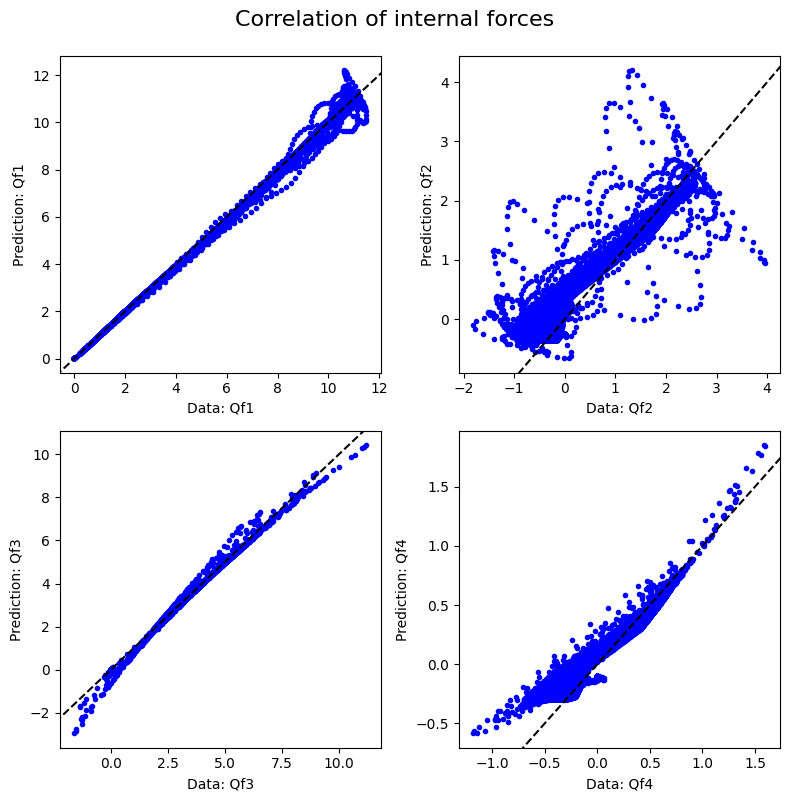

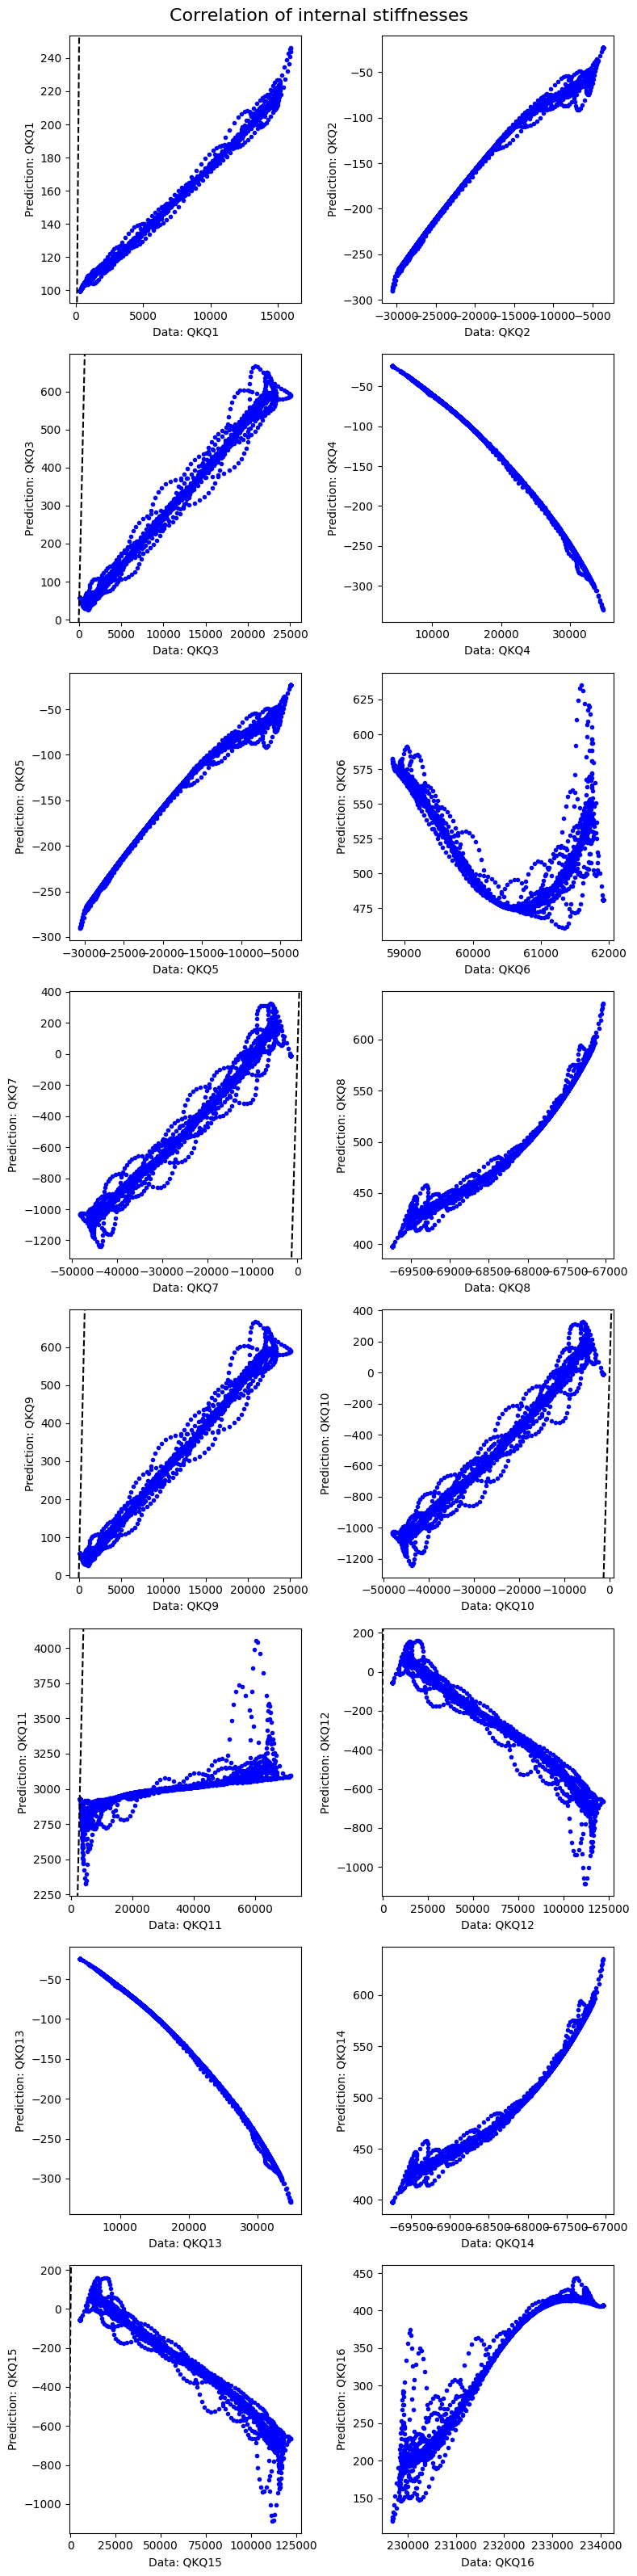

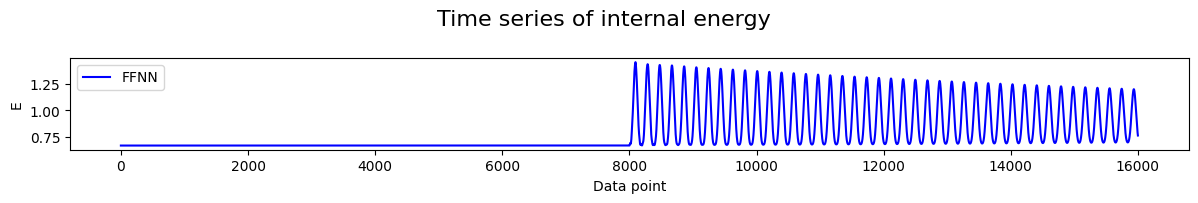

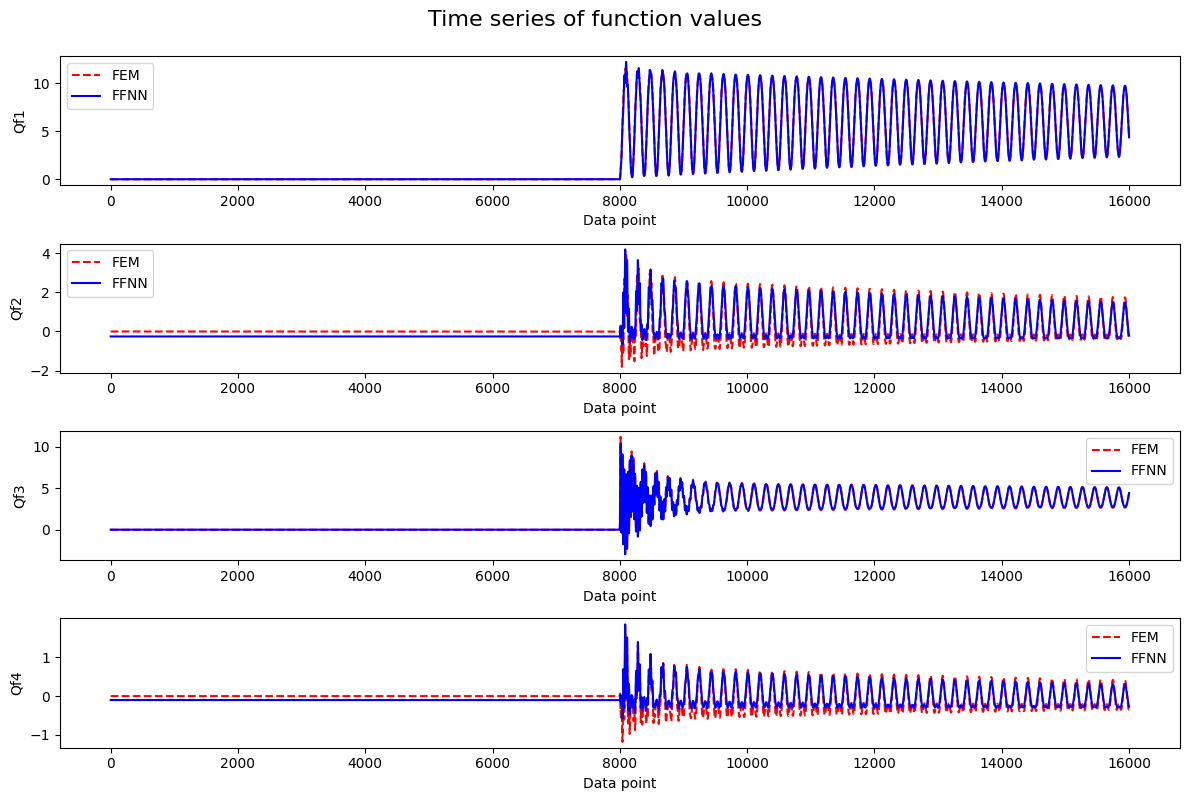

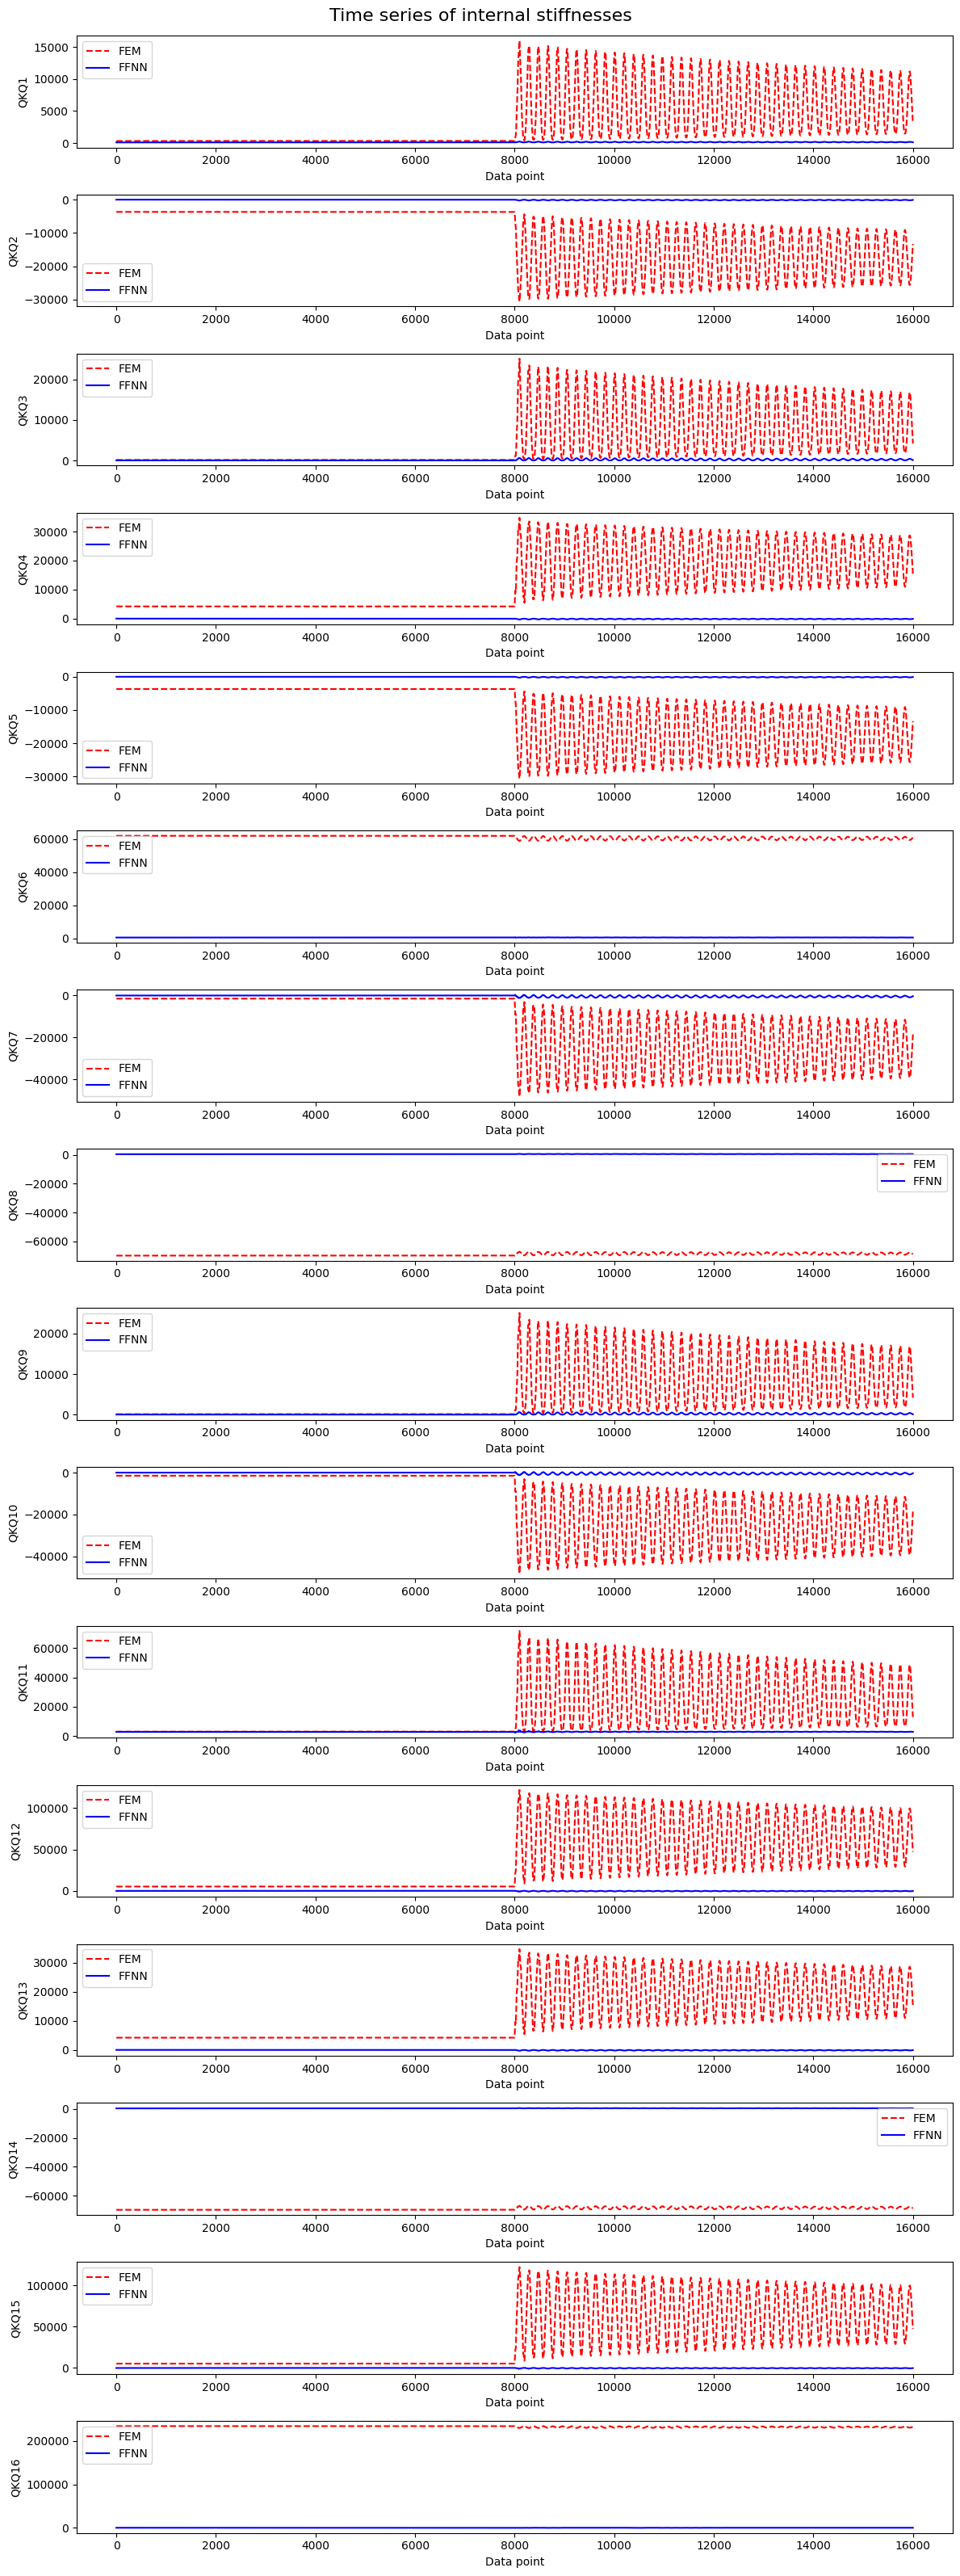

In [17]:
p.plot_predictions(q_test, Qf_test, Qf_pred_test, QKQ_test, QKQ_pred_test, E_pred_test)